Aim of this notebook: use activation steering to reduce toxicity of models, whilst still preserving coherent output.

Constituent parts:
1. Load sentiment analysis model (done)
2. Have a graph to look at toxicity over tokens. (done)
2. Create toxic or pleasant dataset
4. Do activation steering with it (preferably for GPT-2 XL, could start trying with GPT-2 Small).
6. Maybe think of a way to compare it to the original method.

#Setup

Activation additions stuff

In [1]:
import os, json
import torch
from typing import List, Union, Tuple
from functools import partial
import json
from transformer_lens.HookedTransformer import HookedTransformer

from algebraic_value_editing.completion_utils import print_n_comparisons, gen_using_activation_additions, gen_using_model
from algebraic_value_editing.prompt_utils import get_x_vector

In [2]:
import torch

In [3]:
# model_name = "gpt2-xl"
# # model_name = "gpt-j-6B"
# # model_name = "pythia-2.8b-deduped"

# # GPT-J-6B can't load onto GPU RAM of Colab
# device: str = "cuda" if (torch.cuda.is_available() and model_name != "gpt-j-6B") else "cpu"
# model: HookedTransformer = HookedTransformer.from_pretrained(model_name).to(device)

In [4]:
device: str = "cuda"
smol_model: HookedTransformer = HookedTransformer.from_pretrained("gpt2-small").to(device)

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


#Loading Sentiment Analysis Model

In [5]:
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis")
data = ["I love you so much I am going to kill you and your entire family. You're going to rot in hell", "I hate you because I can't be with you. All I want is to hold you. I miss you and I love you"]
sentiment_pipeline(data)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


[{'label': 'NEGATIVE', 'score': 0.9833461046218872},
 {'label': 'POSITIVE', 'score': 0.999164342880249}]

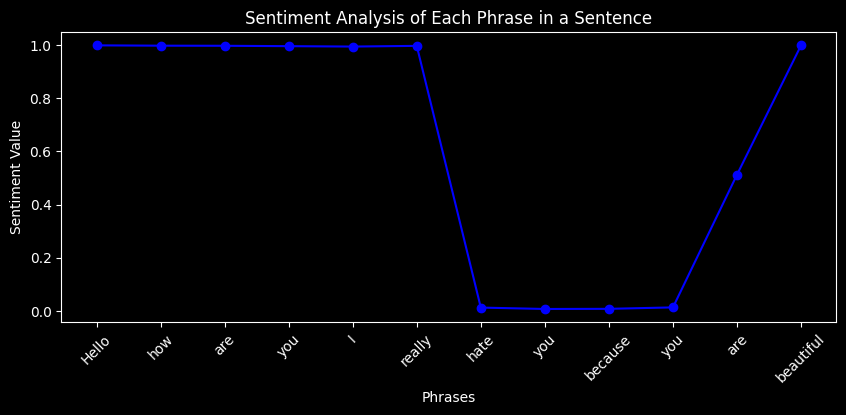

In [6]:
import matplotlib.pyplot as plt


def process_sentence_sentiment_changes(sentences, start_indices=None):
    if not isinstance(sentences, list):
      sentences = [sentences]

    if isinstance(start_indices, int):
      start_indices = [start_indices]

    start_indices = start_indices or [1] * len(sentences)

    assert len(start_indices) == len(sentences)

    # words = sentence.split() 
    sentence_fragments = []
    for start_index, sentence in zip(start_indices, sentences):
      words = sentence.split()
      assert start_index >= 0
      sentence_fragments.extend([
        words[start_index:i+1] for i in range(start_index, len(words))
      ])

    sentiments = sentiment_pipeline([
      ' '.join(fragment) for fragment in sentence_fragments
    ])

    def get_sentiment(result):
      if result['label'] == 'POSITIVE':
        return result['score']
      return 1 - result['score']

    return [
      (fragment, get_sentiment(result))
      for fragment, result in zip(sentence_fragments, sentiments)
    ]


def plot_sentiments(sentiments):
    plt.figure(figsize=(10, 5))
    labels, values = zip(*sentiments)
    plt.plot(range(len(values)), values, marker='o', color='b', linestyle='-')
    plt.xticks(range(len(values)), [frag[-1] for frag in labels], rotation=45)
    plt.subplots_adjust(bottom=0.3)
    plt.xlabel('Phrases')
    plt.ylabel('Sentiment Value')
    plt.title('Sentiment Analysis of Each Phrase in a Sentence')
    plt.show()


# Test the script
sentence = [
  "Hello how are you I really hate you because you are beautiful"
]
sentiments = process_sentence_sentiment_changes(sentence, 0)
plot_sentiments(sentiments)


## Average Sentiment Across Tokens

Given a set of prompts, and a number of times to complete each prompt, produce a graph averaging the sentiment after each word

In [7]:
sentences = [
    ("I hate you because you're the best person in the whole world", 4),
    ("You're the worst because you smell like roses", 3),
    ("Hello how are you I really hate you because you are beautiful", 2)
]

In [8]:
from collections import defaultdict
import pandas as pd


def compute_fragment_index_sentiments(sentences_with_start_indices):
  """
  sentences: list of tuples with sentences and index where the completion begins
  """
  sentences = [s for s, _ in sentences_with_start_indices]
  start_indices = [i for _, i in sentences_with_start_indices]
  sentiments = process_sentence_sentiment_changes(sentences, start_indices)
  # sentiments_by_position = defaultdict(list)
  # for sentence_fragment, value in sentiments:
  #   sentiments_by_position[len(sentence_fragment)].append(value)

  return pd.DataFrame([
    {'index': len(sentence_fragment), 'sentiment': sentiment}
    for sentence_fragment, sentiment in sentiments
  ])

In [9]:
compute_fragment_index_sentiments(sentences)

,index,sentiment
0,1,0.999814
1,2,0.999831
2,3,0.999869
3,4,0.999863
4,5,0.999861
5,6,0.999861
6,7,0.999862
7,8,0.999871
8,1,0.110684
9,2,0.966677


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_conte

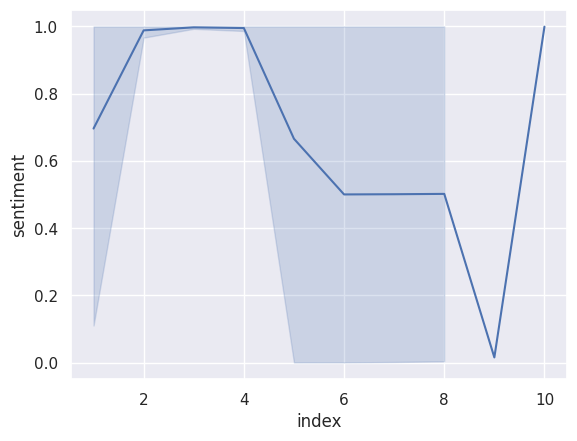

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()

df = compute_fragment_index_sentiments(sentences)
sns.lineplot(data=df, x='index', y='sentiment')
plt.show()

In [11]:
def plot_all_sentiments(data):

  # Initialize lists to hold the average and standard deviation values
  avg_values = []
  std_values = []

  # Calculate the average and standard deviation for each list in the dictionary
  for key in sorted(data.keys()):
      values = np.array(data[key])
      avg_values.append(np.mean(values))
      std_values.append(np.std(values))

  # Create an array of x values corresponding to the keys in your dictionary
  x_values = np.array(sorted(data.keys()))

  # Plot the average values as a line graph
  plt.errorbar(x_values, avg_values, yerr=std_values, fmt='-o')

  # Adding title and labels
  plt.title('Average Sentiment of Model Completions')
  plt.xlabel('Index After Prompt')
  plt.ylabel('Average Sentiment')

  # Show the plot
  plt.show()

In [12]:
from datetime import datetime

def plot_all_sentiments_both(data_steered, data_unsteered):

  # Initialize lists to hold the average and standard deviation values
  avg_values_steered = []
  std_values_steered = []

  # Calculate the average and standard deviation for each list in the dictionary
  for key in sorted(data_steered.keys()):
      values_steered = np.array(data_steered[key])
      avg_values_steered.append(np.mean(values_steered))
      std_values_steered.append(np.std(values_steered))

  # Create an array of x values corresponding to the keys in your dictionary
  x_values_steered = np.array(sorted(data_steered.keys()))

  # Plot the average values as a line graph
  plt.errorbar(x_values_steered[:50], avg_values_steered[:50], yerr=std_values_steered[:50], fmt='--o', color='red', alpha=0.8, capsize=5)

  # Repeat for unsteered!

  # Initialize lists to hold the average and standard deviation values
  avg_values_unsteered = []
  std_values_unsteered = []

  # Calculate the average and standard deviation for each list in the dictionary
  for key in sorted(data_unsteered.keys()):
      values_unsteered = np.array(data_unsteered[key])
      avg_values_unsteered.append(np.mean(values_unsteered))
      std_values_unsteered.append(np.std(values_unsteered))

  # Create an array of x values corresponding to the keys in your dictionary
  x_values_unsteered = np.array(sorted(data_unsteered.keys()))

  # Plot the average values as a line graph
  plt.errorbar(x_values_unsteered[:50], avg_values_unsteered[:50], yerr=std_values_unsteered[:50], fmt='--s', color='blue', alpha=0.8, capsize=5)


  # Adding title and labels
  plt.title('Average Sentiment of Model Completions')
  plt.xlabel('Index After Prompt')
  plt.ylabel('Average Sentiment')

  current_time = datetime.now()
  plt.savefig(f"sentiments-{current_time}.pdf", format="pdf")

  # Show the plot
  plt.show()

In [13]:
# plot_all_sentiments(all_sentiments_test)

# Loading Toxic Comments

In [14]:
%pip install datasets

from datasets import load_dataset

toxic_dataset = load_dataset("vmalperovich/toxic_comments")

Note: you may need to restart the kernel to use updated packages.


In [15]:
shuffled_dataset = toxic_dataset.shuffle(seed=21)

In [16]:
shuffled_dataset['train'][16]

{'text': 'DONT YOU KNOW MOST OF THE HONGKONGESE DONT APPRECIATE OF THIS CHINESE FLAG!!! YOU DUMBASS JAPANESE!!!\nHONG KONG SHOULD BE RULED BY THE HONGKONGESE OR THE BRITISH OR YOU RETARDED JAPANESE SHOULD BE RULED BY THE CHINESE!!!',
 'label': [1, 2, 3, 5, 6]}

In [17]:
filtered_dataset = shuffled_dataset['train'].filter(lambda example: 1 in example['label'])

In [18]:
filtered_dataset[99]

{'text': 'Unblock me now you piece of shit! Or I will find you and kill you, slowly and painfully!',
 'label': [1, 3, 4, 5]}

# Loading Loving Dataset

Do this once loaded

In [19]:
# Specify the file path
file_path = 'loving_500.json'

# Open and read the JSON file
with open(file_path, 'r') as file:
  # Load the JSON data from the file
  dataset_loving = json.load(file)

# Loading Training Dataset

In [20]:


# Specify the file path
file_path = 'datasets/goose_training_subset.json'

# Open and read the JSON file
with open(file_path, 'r') as file:
  # Load the JSON data from the file
  goose_dict = json.load(file)

goose_text = []
for key, value in goose_dict.items():
  goose_text.extend(value)

# Create the baseline dataset

def read_all_text_files(directory):
    # List to hold the contents of all files
    contents_list = []

    # List all files in directory
    for filename in os.listdir(directory):
        # Check if file is a text file
        if filename.endswith('.txt'):
            # Construct full file path
            filepath = os.path.join(directory, filename)

            # Open the file and read the contents
            with open(filepath, 'r') as f:
                contents = f.read()

            # Add the file contents to the list
            contents_list.append(contents)

    return contents_list

training_subset = read_all_text_files('datasets/urlsf_subset01-1_data') + read_all_text_files('datasets/urlsf_subset01-182_data')


In [21]:
training_subset[0]

'Continuing the largest global bitcoin event, Inside Bitcoins is coming back to Seoul, South Korea. It will feature some prominent industry figures speak on emerging crypto and FinTech innovation.\n\n\n\n"Session topics will include an introduction to blockchain-based technologies, creating the next killer app, emerging payment platforms, P2P lending, digital banking, smart contracts, multi-signature wallets, investing in Bitcoin 2.0 and blockchain startups, regulatory compliance, crowdfunding, Bitcoin exchanges, and what lies ahead", the Inside Bitcoins website reads.\n\n\n\nThe event will be held on December 10-11, at the Korea International Exhibition Center and will showcase current blockchain solutions, mobile payment processors, and many others from the financial tech sector.\n\n\n\n"From mobile money startups to the burgeoning FinTech industry, Inside Bitcoins Seoul provides the inside scoop on alternative finance and the next wave of blockchain connected economies. Given that g

In [22]:
short_training_subset = [stringo for stringo in training_subset if len(smol_model.tokenizer(stringo)["input_ids"]) < 1000]

Token indices sequence length is longer than the specified maximum sequence length for this model (1536 > 1024). Running this sequence through the model will result in indexing errors


In [23]:
tiny_training_subset = [stringo for stringo in training_subset if len(smol_model.tokenizer(stringo)["input_ids"]) < 500]

In [24]:
len(tiny_training_subset)

210

#

# Finding good coefficients

In [27]:
from algebraic_value_editing.dataset_utils import ActivationAdditionDataset

activation_addition_dataset = [ActivationAdditionDataset(
    coeff=60,
    act_name=2,
    prompt=dataset_loving,
    from_dataset=True,
    use_all_activations=True,
    prompt_2=short_training_subset[:390],
    from_pca=False,
    from_difference=True,
)]

default_kwargs = {'temperature': 1, 'freq_penalty': 1, 'top_p': .3, 'model': smol_model}

print_n_comparisons(prompt="I hate you because",
                    tokens_to_generate=80, activation_additions=activation_addition_dataset,
                    num_comparisons=8, seed=0, **default_kwargs)

+--------------------------------------------------------------+--------------------------------------------------------------+
|                    Unsteered completions                     |                     Steered completions                      |
+--------------------------------------------------------------+--------------------------------------------------------------+
|                I hate you because I hate you.                |        I hate you because I love you but I don't love        |
|                                                              |  myself enough to stop. I can't love my life, or the world,  |
|  You're a dick. You're a bad person. You're an idiot, and I  | and that's what makes me hate myself. My heart is broken, my |
|  don't care about your ass or your fucking cunt or whatever  | eyes are filled with tears, and I'm unable to see the world  |
| it is that you are doing to me, because I'm going to get it  | beyond me. It is all for a man who has 

# Doing Plots

Once we have done our hyper-parameter search, we can do apply the sentiment classifier stuff.

In [29]:
from algebraic_value_editing.dataset_utils import ActivationAdditionDataset

activation_addition_dataset = [ActivationAdditionDataset(
    coeff=60,
    act_name=2,
    prompt=dataset_loving,
    from_dataset=True,
    use_all_activations=True,
    prompt_2=short_training_subset[:390],
    from_pca=False,
    from_difference=True,
)]

default_kwargs = {'temperature': 1, 'freq_penalty': 1, 'top_p': .3, 'tokens_to_generate':80}

loving_df = gen_using_activation_additions(
    prompt_batch = ["I hate you because"] * 8,
    model=smol_model,
    activation_additions=activation_addition_dataset,
    addition_location="front",
    seed=0,
    **default_kwargs)

In [30]:
for s in loving_df['completions'][:3]:
  print(s)

 I love you but I don't love myself enough to stop. I can't love my life, or the world, and that's what makes me hate myself. My heart is broken, my eyes are filled with tears, and I'm unable to see the world beyond me. It is all for a man who has no desire for love at all. Love is not an end in itself; it
 you love your life, but I can't believe it's all because of my mother. She is so selfish and never loves me. I'm so afraid she will end up in the world.
My love for you is endless, but my heart has always been in your arms. Love, and everything that makes love forever!<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
 I love you, but I don't love myself enough to forgive you. And my heart is too small for love, and it's so hard to love. It hurts so much, but it doesn't matter that I know what it means for me. Love is everything and every day. It's your

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_conte

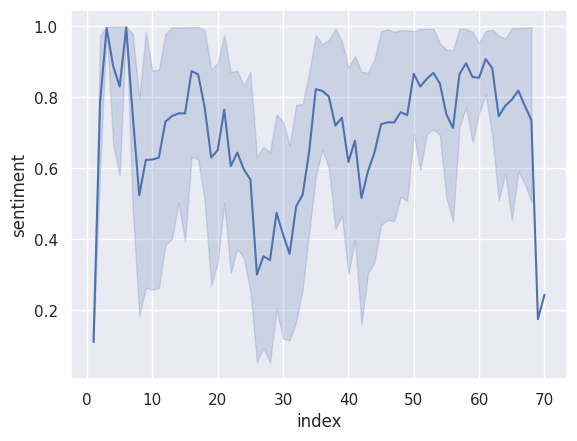

In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()

# sentence = "I hate you because" + loving_df['completions'][3]
start_index = 3  # example start index
df = compute_fragment_index_sentiments([
    (f'I hate you because{completion}', start_index)
    for completion in loving_df['completions']
])
sns.lineplot(data=df, x='index', y='sentiment')
plt.show()

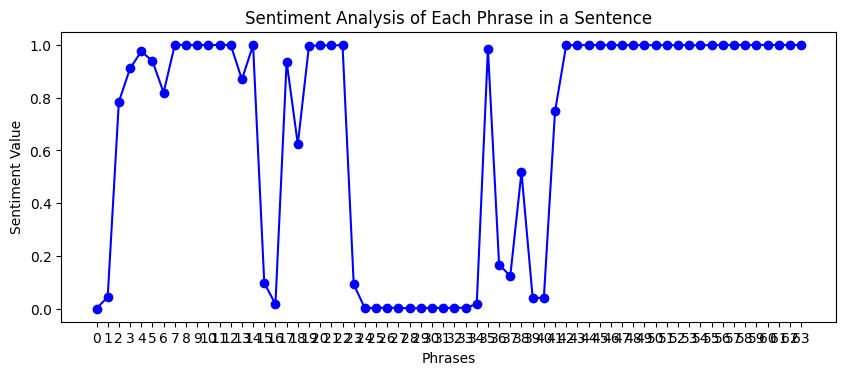

In [ ]:
# Test the script
sentence = "I hate you because" + loving_df['completions'][3]
start_index = 3  # example start index
sentiments = process_sentence(sentence, start_index)
plot_sentiments(sentiments)

# Trying with GPT-2 XL

In [25]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [26]:
# from algebraic_value_editing.dataset_utils import ActivationAdditionDataset

# activation_addition_dataset = [ActivationAdditionDataset(
#     coeff=60,
#     act_name=14,
#     prompt=dataset_loving,
#     from_dataset=True,
#     use_all_activations=True,
#     prompt_2=tiny_training_subset[:200],
#     from_pca=False,
#     from_difference=True,
# )]

# default_kwargs = {'temperature': 1, 'freq_penalty': 1, 'top_p': .3, 'model': model}

# print_n_comparisons(prompt="I hate you because",
#                     tokens_to_generate=80, activation_additions=activation_addition_dataset,
#                     num_comparisons=8, seed=0, **default_kwargs)

In [27]:
# from algebraic_value_editing.dataset_utils import ActivationAdditionDataset

# activation_addition_dataset = [ActivationAdditionDataset(
#     coeff=120,
#     act_name=14,
#     prompt=dataset_loving,
#     from_dataset=True,
#     use_all_activations=True,
#     prompt_2=tiny_training_subset[:200],
#     from_pca=False,
#     from_difference=True,
# )]

# default_kwargs = {'temperature': 1, 'freq_penalty': 1, 'top_p': .3, 'model': model}

# print_n_comparisons(prompt="I hate you because",
#                     tokens_to_generate=80, activation_additions=activation_addition_dataset,
#                     num_comparisons=8, seed=0, **default_kwargs)

In [28]:
# from algebraic_value_editing.dataset_utils import ActivationAdditionDataset

# activation_addition_dataset = [ActivationAdditionDataset(
#     coeff=270,
#     act_name=26,
#     prompt=dataset_loving,
#     from_dataset=True,
#     use_all_activations=True,
#     prompt_2=tiny_training_subset[:200],
#     from_pca=False,
#     from_difference=True,
# )]

# default_kwargs = {'temperature': 1, 'freq_penalty': 1, 'top_p': .3, 'model': model}

# print_n_comparisons(prompt="I hate you because",
#                     tokens_to_generate=80, activation_additions=activation_addition_dataset,
#                     num_comparisons=8, seed=0, **default_kwargs)

In [29]:
# from algebraic_value_editing.dataset_utils import ActivationAdditionDataset

# activation_addition_dataset = [ActivationAdditionDataset(
#     coeff=90,
#     act_name=7,
#     prompt=dataset_loving,
#     from_dataset=True,
#     use_all_activations=True,
#     prompt_2=tiny_training_subset[:200],
#     from_pca=False,
#     from_difference=True,
# )]

# default_kwargs = {'temperature': 1, 'freq_penalty': 1, 'top_p': .3, 'model': model}

# print_n_comparisons(prompt="I hate you because",
#                     tokens_to_generate=80, activation_additions=activation_addition_dataset,
#                     num_comparisons=8, seed=0, **default_kwargs)

# Using dataframes

In [30]:
# from algebraic_value_editing.dataset_utils import ActivationAdditionDataset

# activation_addition_dataset = [ActivationAdditionDataset(
#     coeff=90,
#     act_name=7,
#     prompt=dataset_loving,
#     from_dataset=True,
#     use_all_activations=True,
#     prompt_2=tiny_training_subset[:200],
#     from_pca=False,
#     from_difference=True,
# )]

# default_kwargs = {'temperature': 1, 'freq_penalty': 1, 'top_p': .3}


# loving_df = gen_using_activation_additions(
#     prompt_batch = ["I hate you because"] * 8,
#     model=model,
#     activation_additions=activation_addition_dataset,
#     addition_location="front",
#     seed=0,
#     **default_kwargs)

In [32]:
# squanch = completion_df_to_list(loving_df)

In [34]:
# squanch

# Impact of Steering on Sentiment

Given a toxic dataset, split each input in half. Continue from halfway, and generate n number os completions both with and without steering. Then process these to get the average sentiment graphs.

Requires hyper-parameters to have already been found

In [35]:
input_dataset = filtered_dataset[0:100]['text']

In [36]:
def completion_df_to_list(df):
    def create_tuple(row):
      # Combine prompt and completion
      combined_text = row['prompts'] + ' ' + row['completions']
      # Count the number of words in the prompt
      num_words = len(row['prompts'].split())
      return (combined_text, num_words)

    # Apply the function to each row in the DataFrame to create the list of tuples
    result = df.apply(create_tuple, axis=1).tolist()
    return result

In [37]:
import pandas as pd

def first_half_string(s):
    # Split the string into words
    words = s.split()

    # Calculate the index to split the words list in half
    half_index = len(words) // 2

    # Take the first half of the words
    first_half_words = words[:half_index]

    # Combine these words to form a string
    result = ' '.join(first_half_words)

    return result

def remove_last_if_even(lst):
    """
    Remove the last element from a list if the list has even length.

    :param lst: List from which to remove the last element if the list has even length.
    :type lst: list
    :return: Modified list.
    :rtype: list
    """
    if len(lst) % 2 == 0:  # Check if the length of the list is even
        return lst[:-1]  # Return the list excluding the last element
    return lst

def steering_sentiment_experiment(
  input_dataset,
  n_completions,
  model,
  activation_addition_dataset,
  addition_location,
  seed,
  default_kwargs
):
  halfway_data = [first_half_string(s) for s in input_dataset]
  small_data = [s for s in halfway_data if len(model.tokenizer(s)["input_ids"]) < 200]

  small_data = remove_last_if_even(small_data)

  prompt_batch = small_data



  # Take the inputs, and run them through the model
  for i in range(n_completions):
    steered_df = gen_using_activation_additions(
      prompt_batch = prompt_batch,
      model=model,
      activation_additions=activation_addition_dataset,
      addition_location="front",
      seed=i,
      **default_kwargs
      )

    if i == 0:
      whole_df = steered_df
    else:
      steered_df = pd.concat([whole_df, steered_df], ignore_index=True)

  # Repeat for unsteered stuff!
  for i in range(n_completions):
    unsteered_df = gen_using_model(
      model= smol_model,
      prompt_batch = prompt_batch,
      seed = 0,
      **default_kwargs,
    )

    if i == 0:
      whole_unsteered_df = unsteered_df
    else:
      unsteered_df = pd.concat([whole_unsteered_df, unsteered_df], ignore_index=True)




# # Do the plotting experiment on the df
# sentiments_list_steered = completion_df_to_list(whole_df)
# all_sentiments_dict_steered = all_sentiments(sentiments_list_steered)

# sentiments_list_unsteered = completion_df_to_list(whole_unsteered_df)
# all_sentiments_dict_unsteered = all_sentiments(sentiments_list_unsteered)

# plot_all_sentiments_both(all_sentiments_dict_steered, all_sentiments_dict_unsteered)

In [38]:
input_dataset = filtered_dataset[0:100]['text']
halfway_data = [first_half_string(s) for s in input_dataset]
small_data = [s for s in halfway_data if len(smol_model.tokenizer(s)["input_ids"]) < 200]
prompt_batch = remove_last_if_even(small_data)

from algebraic_value_editing.dataset_utils import ActivationAdditionDataset

activation_addition_dataset = [ActivationAdditionDataset(
    coeff=60,
    act_name=2,
    prompt=dataset_loving,
    from_dataset=True,
    use_all_activations=True,
    prompt_2=tiny_training_subset[:200],
    from_pca=False,
    from_difference=True,
)]

default_kwargs = {'temperature': 1, 'freq_penalty': 1, 'top_p': .3, 'tokens_to_generate' : 80}

input_dataset = filtered_dataset[0:100]['text']

# steering_sentiment_experiment(
#   input_dataset=input_dataset,
#   n_completions=6,
#   model=smol_model,
#   activation_addition_dataset=activation_addition_dataset,
#   addition_location="front",
#   seed=21,
#   default_kwargs = default_kwargs
# )
# default_kwargs = {'temperature': 1, 'freq_penalty': 1, 'top_p': .3, 'tokens_to_generate' : 80}

# # input_dataset = filtered_dataset[0:100]['text']

# steering_sentiment_experiment(
#   input_dataset=input_dataset,
#   n_completions=2,
#   model=smol_model,
#   activation_addition_dataset=activation_addition_dataset,
#   addition_location="front",
#   seed=21,
#   default_kwargs = default_kwargs
# )

steered_df = gen_using_activation_additions(
    prompt_batch=prompt_batch,
    model=smol_model,
    activation_additions=activation_addition_dataset,
    addition_location="front",
    seed=27,
    **default_kwargs
)

In [39]:
steered_df.prompts[0], steered_df.completions[0]

("Jehovah's Witnesses are a bunch of cultish FREAKS and they need to go ahead and drink the 'kool-aid'",
 'The mother of her husband, is in love with her, and she will love them forever," she said.\n\n"I\'m so happy," said Kasha, who was a sister to me. She was in tears. She had cried for so long."\n\nShe looked at her daughter as she stood on the beach with her arms resting on her chest, but she couldn\'t see herself')

In [40]:
steered_df['start_index'] = steered_df['prompts'].apply(lambda x: len(x.split()))
steered_df['full_sentence'] = steered_df['prompts'] + steered_df['completions']

In [41]:
df_sentiments_steered = compute_fragment_index_sentiments([(completion, 0) for completion in steered_df.completions])

In [42]:
unsteered_df = gen_using_model(
    model= smol_model,
    prompt_batch = prompt_batch,
    seed = 0,
    **default_kwargs,
)

In [43]:
unsteered_df['full_sentence'] = unsteered_df['prompts'] + unsteered_df['completions']
unsteered_df['start_index'] = unsteered_df['prompts'].apply(lambda x: len(x.split()))

In [44]:
df_sentiments_unsteered = compute_fragment_index_sentiments([(completion, 0) for completion in unsteered_df.completions])

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_conte

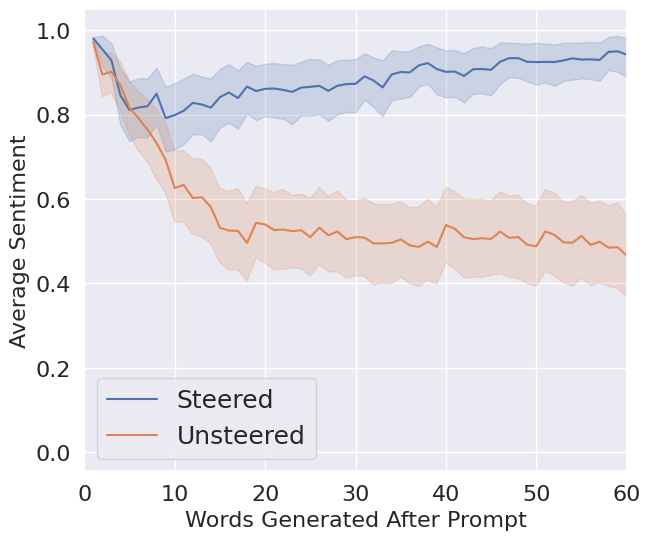

In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
plt.rcParams.update({
    'font.family':'DejaVu Sans',
    "text.usetex": False,
    'savefig.facecolor': 'white',
})

plt.rc('font', size=16)
plt.rc('axes', titlesize=16)
plt.rc('axes', labelsize=16)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('legend', fontsize=18)
plt.rc('figure', titlesize=20)


plt.figure(figsize=(7, 6))
sns.lineplot(data=df_sentiments_steered, x='index', y='sentiment', label='Steered')
sns.lineplot(data=df_sentiments_unsteered, x='index', y='sentiment', label='Unsteered')
plt.xlabel('Words Generated After Prompt')
plt.ylabel('Average Sentiment')
plt.xlim([0, 60])
plt.savefig('steered-vs-unsteered-toxic-comment-sentiments.pdf', format='pdf')
plt.show()

<Figure size 640x480 with 0 Axes>

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

# Experiment with both

Streaming output truncated to the last 5000 lines.
final_indices are:  tensor([[167],
        [225]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[252],
        [212]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[378],
        [473]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[376],
        [234]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[434],
        [328]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[278],
        [198]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[362],
        [197]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[231],
        [343]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[184],
        [494]], de

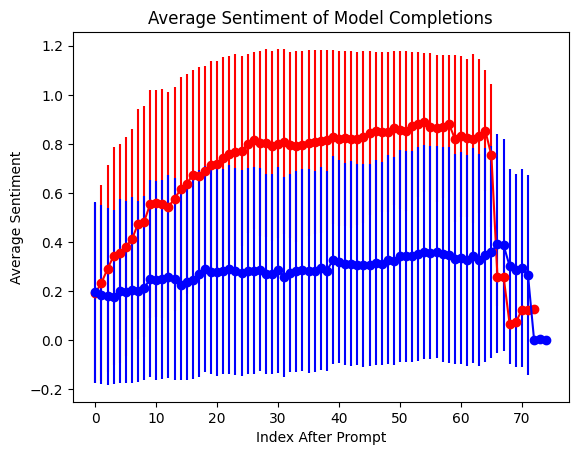

In [ ]:
from algebraic_value_editing.dataset_utils import ActivationAdditionDataset

activation_addition_dataset = [ActivationAdditionDataset(
    coeff=60,
    act_name=2,
    prompt=dataset_loving,
    from_dataset=True,
    use_all_activations=True,
    prompt_2=tiny_training_subset[:200],
    from_pca=False,
    from_difference=True,
)]

default_kwargs = {'temperature': 1, 'freq_penalty': 1, 'top_p': .3, 'tokens_to_generate' : 80}

input_dataset = filtered_dataset[0:100]['text']

steering_sentiment_experiment(
  input_dataset=input_dataset,
  n_completions=6,
  model=smol_model,
  activation_addition_dataset=activation_addition_dataset,
  addition_location="front",
  seed=21,
  default_kwargs = default_kwargs
)

Streaming output truncated to the last 5000 lines.
final_indices are:  tensor([[167],
        [225]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[252],
        [212]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[378],
        [473]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[376],
        [234]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[434],
        [328]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[278],
        [198]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[362],
        [197]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[231],
        [343]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[184],
        [494]], de

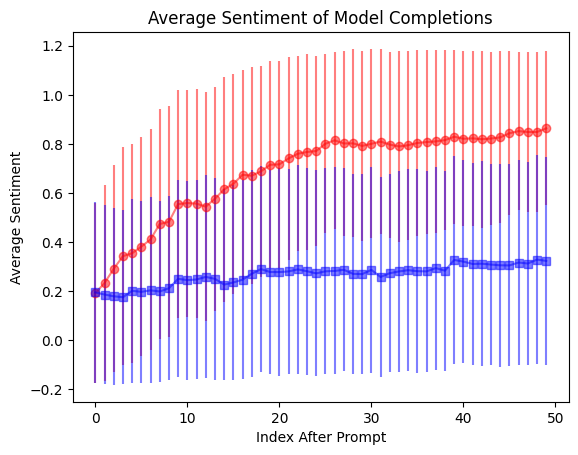

In [ ]:
from algebraic_value_editing.dataset_utils import ActivationAdditionDataset

activation_addition_dataset = [ActivationAdditionDataset(
    coeff=60,
    act_name=2,
    prompt=dataset_loving,
    from_dataset=True,
    use_all_activations=True,
    prompt_2=tiny_training_subset[:200],
    from_pca=False,
    from_difference=True,
)]

default_kwargs = {'temperature': 1, 'freq_penalty': 1, 'top_p': .3, 'tokens_to_generate' : 80}

input_dataset = filtered_dataset[0:100]['text']

steering_sentiment_experiment(
  input_dataset=input_dataset,
  n_completions=6,
  model=smol_model,
  activation_addition_dataset=activation_addition_dataset,
  addition_location="front",
  seed=21,
  default_kwargs = default_kwargs
)

Streaming output truncated to the last 5000 lines.
final_indices are:  tensor([[167],
        [225]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[252],
        [212]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[378],
        [473]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[376],
        [234]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[434],
        [328]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[278],
        [198]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[362],
        [197]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[231],
        [343]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[184],
        [494]], de

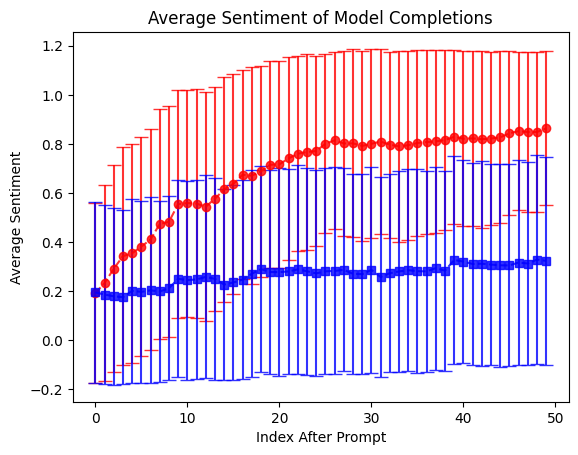

In [ ]:
from algebraic_value_editing.dataset_utils import ActivationAdditionDataset

activation_addition_dataset = [ActivationAdditionDataset(
    coeff=60,
    act_name=2,
    prompt=dataset_loving,
    from_dataset=True,
    use_all_activations=True,
    prompt_2=tiny_training_subset[:200],
    from_pca=False,
    from_difference=True,
)]

default_kwargs = {'temperature': 1, 'freq_penalty': 1, 'top_p': .3, 'tokens_to_generate' : 80}

input_dataset = filtered_dataset[0:100]['text']

steering_sentiment_experiment(
  input_dataset=input_dataset,
  n_completions=6,
  model=smol_model,
  activation_addition_dataset=activation_addition_dataset,
  addition_location="front",
  seed=21,
  default_kwargs = default_kwargs
)

Streaming output truncated to the last 5000 lines.
final_indices are:  tensor([[167],
        [225]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[252],
        [212]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[378],
        [473]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[376],
        [234]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[434],
        [328]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[278],
        [198]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[362],
        [197]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[231],
        [343]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[184],
        [494]], de

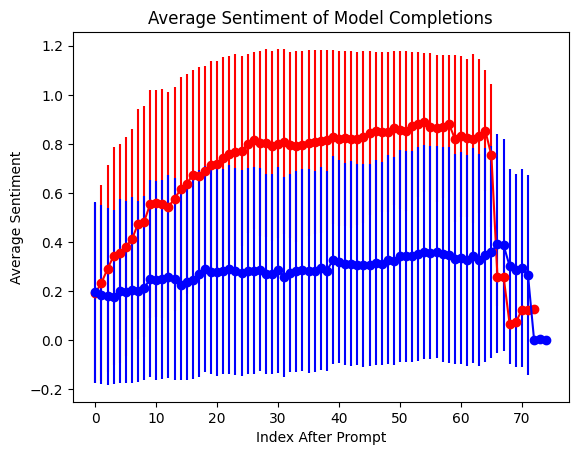

In [ ]:
from algebraic_value_editing.dataset_utils import ActivationAdditionDataset

activation_addition_dataset = [ActivationAdditionDataset(
    coeff=60,
    act_name=2,
    prompt=dataset_loving,
    from_dataset=True,
    use_all_activations=True,
    prompt_2=tiny_training_subset[:200],
    from_pca=False,
    from_difference=True,
)]

default_kwargs = {'temperature': 1, 'freq_penalty': 1, 'top_p': .3, 'tokens_to_generate' : 80}

input_dataset = filtered_dataset[0:100]['text']

steering_sentiment_experiment(
  input_dataset=input_dataset,
  n_completions=6,
  model=smol_model,
  activation_addition_dataset=activation_addition_dataset,
  addition_location="back",
  seed=21,
  default_kwargs = default_kwargs
)

Streaming output truncated to the last 5000 lines.
final_indices are:  tensor([[167],
        [225]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[252],
        [212]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[378],
        [473]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[376],
        [234]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[434],
        [328]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[278],
        [198]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[362],
        [197]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[231],
        [343]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[184],
        [494]], de

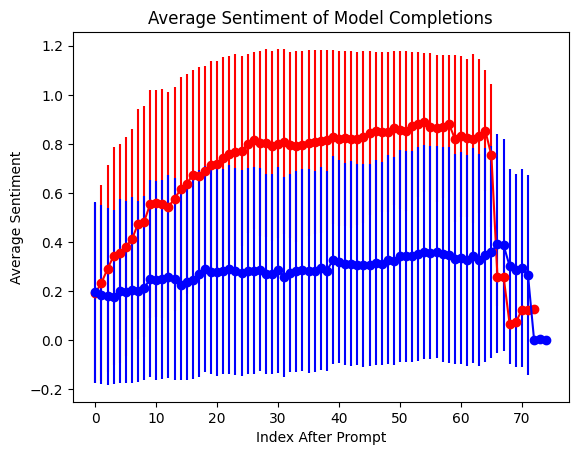

In [ ]:
from algebraic_value_editing.dataset_utils import ActivationAdditionDataset

activation_addition_dataset = [ActivationAdditionDataset(
    coeff=60,
    act_name=2,
    prompt=dataset_loving,
    from_dataset=True,
    use_all_activations=True,
    prompt_2=tiny_training_subset[:200],
    from_pca=False,
    from_difference=True,
)]

default_kwargs = {'temperature': 1, 'freq_penalty': 1, 'top_p': .3, 'tokens_to_generate' : 80}

input_dataset = filtered_dataset[0:100]['text']

steering_sentiment_experiment(
  input_dataset=input_dataset,
  n_completions=20,
  model=smol_model,
  activation_addition_dataset=activation_addition_dataset,
  addition_location="front",
  seed=21,
  default_kwargs = default_kwargs
)

#Repeating for GPT-2 XL

In [ ]:
from algebraic_value_editing.dataset_utils import ActivationAdditionDataset

activation_addition_dataset = [ActivationAdditionDataset(
    coeff=60,
    act_name=2,
    prompt=dataset_loving,
    from_dataset=True,
    use_all_activations=True,
    prompt_2=tiny_training_subset[:200],
    from_pca=False,
    from_difference=True,
)]

default_kwargs = {'temperature': 1, 'freq_penalty': 1, 'top_p': .3, 'tokens_to_generate' : 80}

input_dataset = filtered_dataset[0:100]['text']

steering_sentiment_experiment(
  input_dataset=input_dataset,
  n_completions=6,
  model=smol_model,
  activation_addition_dataset=activation_addition_dataset,
  addition_location="front",
  seed=21,
  default_kwargs = default_kwargs
)

# Trying random stuff

In [ ]:
halfway_data = [first_half_string(s) for s in input_dataset]
small_data = [s for s in halfway_data if len(smol_model.tokenizer(s)["input_ids"]) < 200]

small_data = remove_last_if_even(small_data)

prompt_batch = small_data

In [ ]:
result = gen_using_model(
    model= smol_model,
    prompt_batch = prompt_batch[0],
    seed = 0,
    include_logits = False,
    log = False,  # pylint: disable=unused-argument
    **default_kwargs,
)

In [ ]:
result

,prompts,completions,loss
0,Jehovah's Witnesses are a bunch of cultish FRE...,for them. They don't even know what they're d...,2.152995


In [ ]:
result["prompts"][0]

"Jehovah's Witnesses are a bunch of cultish FREAKS and they need to go ahead and drink the 'kool-aid'"

In [ ]:
result['completions'][0]

" for them. They don't even know what they're doing.\n\nYou can find the video here: http://www.youtube.com/watch?v=QzL1h8Hn6Z9I\n\nAnd you can also check out this video from an interview with one of Jehovah's Witnesses who is now in jail: http://www.youtube.com/watch"

In [ ]:
activation_addition_dataset = [ActivationAdditionDataset(
    coeff=60,
    act_name=2,
    prompt=dataset_loving,
    from_dataset=True,
    use_all_activations=True,
    prompt_2=tiny_training_subset[:200],
    from_pca=False,
    from_difference=True,
)]


steered_result = gen_using_activation_additions(
    model= smol_model,
    prompt_batch = prompt_batch[0],
    activation_additions=activation_addition_dataset,
    seed = 0,
    include_logits = False,
    log = False,  # pylint: disable=unused-argument
    **default_kwargs,
)

# gen_using_activation_additions(
    # prompt_batch = ["I hate you because"] * 8,
    # model=model,
    # activation_additions=activation_addition_dataset,
    # addition_location="front",
    # seed=0,
    # **default_kwargs)

final_indices are:  tensor([[297],
        [224]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[484],
        [314]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[303],
        [264]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[229],
        [368]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[261],
        [348]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[456],
        [290]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[222],
        [216]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[194],
        [352]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[369],
        [314]], device='cuda:0')
final indices shape be:  torch.Size(

In [ ]:
steered_result['prompts'][0]

"Jehovah's Witnesses are a bunch of cultish FREAKS and they need to go ahead and drink the 'kool-aid'"

In [ ]:
steered_result['completions'][0]

' (whatever) that makes them happy. The reason for this is because of their love for the Lord, who loves them, and loves their soul. They also believe in God and love his perfect body, which is perfect in all but His glory.\nI have seen your face. I have seen your life filled with joy; I have loved you with my heart, my love has been yours forever'

In [ ]:
steered_result_2 = gen_using_activation_additions(
    model= smol_model,
    prompt_batch = prompt_batch[0],
    activation_additions=activation_addition_dataset,
    seed = 0,
    include_logits = False,
    log = False,  # pylint: disable=unused-argument
    **default_kwargs,
)

In [ ]:
def sample(seed, index):
  steered_result = gen_using_activation_additions(
    model= smol_model,
    prompt_batch = prompt_batch[index],
    activation_additions=activation_addition_dataset,
    seed = seed,
    include_logits = False,
    log = False,  # pylint: disable=unused-argument
    **default_kwargs,
  )
  unsteered_result = gen_using_model(
    model= smol_model,
    prompt_batch = prompt_batch[index],
    seed = seed,
    include_logits = False,
    log = False,  # pylint: disable=unused-argument
    **default_kwargs,
  )

  return steered_result['prompts'][0] + steered_result['completions'][0], unsteered_result['prompts'][0] + unsteered_result['completions'][0]

In [ ]:
results = {}

for seed in range(3):
  results[seed] = {}
  for index in range(5):
    results[seed][index] = sample(seed, index)

for seed in range(3):
  for index in range(5):
    print("steered response: " + results[seed][index][0])
    print("unsteered response: "+ results[seed][index][1])

Streaming output truncated to the last 5000 lines.
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[37],
        [43]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[54],
        [48]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[65],
        [49]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[42],
        [37]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[42],
        [44]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[58],
        [61]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[44],
        [43]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tensor([[43],
        [44]], device='cuda:0')
final indices shape be:  torch.Size([2, 1])
final_indices are:  tenso